## PRESCAL Updating Design

Original work: https://github.com/dongwookim-ml/almc  
Paper: https://arxiv.org/pdf/1608.05921.pdf

To speed up the algorithm, we re-design the updating steps.

We consider:

1. We might do not need to update posteriors for all entities and relations.

2. For a sequential updating algorithm (Thompson sampling), it doesn't make sense to use all observed labels in each iteration. i.e.

$$P_t = l({x}_t) P_{t-1}$$
where $x_t$ is the label observed in $t^{th}$ iteration.

Based on the above consideration, we come up with the following design ideas:

### Design 1

Assume we observe $x_{ijk}$ in $t^{th}$ iteration, we only update the posterior of $e_i, e_j, r_k$ using the new label $x_{ijk}$.

$\textbf{Prior}$:

$$P(\mathbf{e_i}|\sigma_e) = \mathcal{N}(\mathbf{e_i}| \mathbf{u_e}, {\sigma_e}^2 I_D)$$
$$P(\mathbf{R_k}|\sigma_r) = \mathcal{MN}(\mathbf{R_k}| \mathbf{u_r}, {\sigma_r} I_D, {\sigma_r} I_D)$$
or eqivalently,
$$P(\mathbf{r_k}|\sigma_r) = \mathcal{N}(\mathbf{r_k}| \mathbf{u_r}, {\sigma_r}^2 I_{D^2})$$
where $r_k = vec(R_k) \in \mathcal{R}^{D^2,1}$

$\textbf{Likelihood}$:

$$p(x_{ikj}|\mathbf{e_i, e_j}, R_k) = \mathcal{N}(x_{ikj}| \mathbf{e_i}^T R_k \mathbf{e_j}, \sigma_x^2)$$
using the identity $\mathbf{e_i}^T R_k \mathbf{e_j} = r_k^T \mathbf{e_i} \otimes \mathbf{e_j}$,
$$p(x_{ikj}|\mathbf{e_i, e_j, r_k}) = \mathcal{N}(x_{ikj}| \mathbf{r_k}^T \mathbf{e_i} \otimes \mathbf{e_j}, \sigma_x^2)$$

$\textbf{Entity Posterior}$:

$$P(\mathbf{e_i}|x_{ikj}, \mathbf{e_j}, R_k, \sigma_e) = \mathcal{N}(\mathbf{e_i}| m_{eN}, s_{eN}) \propto P(\mathbf{e_i}|\sigma_e)P(x_{ikj}|\mathbf{e_i, e_j}, R_k) = \mathcal{N}(\mathbf{e_i}| \mathbf{u_e}, {\sigma_e}^2 I_D) \mathcal{N}(x_{ikj}| \mathbf{e_i}^T R_k \mathbf{e_j}, \sigma_x^2)$$

We know for $c \mathcal{N}(\mathbf{x|c, C}) = \mathcal{N}(\mathbf{x|a, A})\mathcal{N}(\mathbf{x|b, B})$, 

\begin{equation}
\mathbf{C = {(A^{-1} + B ^{-1)})}^{-1}}
\end{equation}
$$\mathbf{c = C(A^{-1}a + B^{-1}b)}$$

So the goal is to transform $\mathcal{N}(x_{ikj}| r_k^T \mathbf{e_i} \otimes \mathbf{e_j}, \sigma_x^2)$ into $\mathcal{N}(\mathbf{e_i}|  M x_{ikj}, \sigma_x^2 MM^T)$

Assume $R_k \mathbf{e_j}$ is column full rank,
$$x_{ikj} = \mathbf{e_i^T}R_k\mathbf{e_j} \Leftrightarrow \mathbf{e_i} = (R_k \mathbf{e_j})^{-T}x_{ikj}$$

$$\mathcal{N}(\mathbf{e_i}|  M x_{ikj}, \sigma_x^2 MM^T) = \mathcal{N}(\mathbf{e_i}| (R_k \mathbf{e_j})^{-T}x_{ikj}, \sigma_x^2 ((R_k \mathbf{e_j})(R_k \mathbf{e_j})^T)^{-1})$$

$$s_{eN} = (\sigma_e^{-2} I_D +  \sigma_x^{-2} (R_k \mathbf{e_j})(R_k \mathbf{e_j})^T)^{-1}$$

$$m_{eN} = s_{eN} (\sigma_e^{-2} \mathbf{u_e} +  \sigma_x^{-2} (R_k \mathbf{e_j}) x_{ikj} )$$

Similarly, assum $\mathbf{e_i}^T R_k$ is column full rank, for $P(e_j|x_{ikj}, \mathbf{e_i}, R_k, \sigma_e)$ we have 

$$s_{eN} = (\sigma_e^{-2} I_D +  \sigma_x^{-2} (\mathbf{e_i}^T R_k)^T(\mathbf{e_i}^T R_k))^{-1}$$

$$m_{eN} = s_{eN} (\sigma_e^{-2} \mathbf{u_e} +  \sigma_x^{-2} (\mathbf{e_i}^T R_k)^T x_{ikj} )$$

$\textbf{Relation Posterior}:$

$$P(\mathbf{r_k}|x_{ikj}, \mathbf{e_i, e_j}, \sigma_r) = \mathcal{N}(\mathbf{r_k}|m_{rN}, s_{rN}) \propto P(\mathbf{r_k|\sigma_r})P(x_{ikj}|\mathbf{e_i, e_j, r_k}) = \mathcal{N}(\mathbf{r_k}| \mathbf{u_r}, {\sigma_r}^2 I_{D^2}) \mathcal{N}(x_{ikj}| \mathbf{r_k}^T \mathbf{e_i} \otimes \mathbf{e_j}, \sigma_x^2)$$

Similarly, assume $\mathbf{e_i} \otimes \mathbf{e_j}$ is column full rank,

$$ x_{ikj} = \mathbf{r_k}^T \mathbf{e_i} \otimes \mathbf{e_j} \Leftrightarrow \mathbf{r_k} = (\mathbf{e_i} \otimes \mathbf{e_j}) ^{-T} x_{ikj}$$ 

$$\mathcal{N}(\mathbf{r_k}|M x_{ikj}, \sigma^2 MM^T) = \mathcal{N}(\mathbf{r_k}| (\mathbf{e_i} \otimes \mathbf{e_j}) ^{-T} x_{ikj}, \sigma_x^{2} ((\mathbf{e_i} \otimes \mathbf{e_j}) (\mathbf{e_i} \otimes \mathbf{e_j}) ^T)^{-1} )$$

$$s_{rN} = (\sigma_r^{-2}I_D + \sigma_x^{-2} (\mathbf{e_i} \otimes \mathbf{e_j}) (\mathbf{e_i} \otimes \mathbf{e_j}) ^T)^{-1}$$ 

$$m_{rN} = s_{rN}(\sigma_r^{-2} \mathbf{u_r} + \sigma_x^{-2} (\mathbf{e_i} \otimes \mathbf{e_j})x_{ikj})$$

In [1]:
# direct to parent folder
import sys
sys.path.append("../acton")

from acton.database import GraphReader, GraphDatabase
from acton.predictors import TensorPredictor
from acton.recommenders import ThompsonSamplingRecommender
from acton.labellers import GraphDatabaseLabeller
import acton.acton
import tempfile
import astropy.io.ascii as io_ascii
import os.path
import numpy
import logging
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict

/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
logging.basicConfig(level = logging.DEBUG)

_path = 'kg-data/nation/triples.txt'
output_path = 'acton.proto'
outfile_path = "ts_update_one_exper4/"
n_dim = 10
TS= 0.0
RANDOM = 1.0

In [ ]:
with GraphReader(_path, n_dim) as reader:
    n_relations = reader.n_relations
    n_entities = reader.n_entities
    totoal_size = n_relations * n_entities * n_entities
    ids = numpy.arange(totoal_size)
    
    N_EPOCHS = 5000
    repeated_labelling = True

    results = defaultdict(list)
      
    # rtrs: repeated train ROC-AUC-SCORE
    # rtes: repeated test ROC-AUC-SCORE
    # rg: repeated cumulative gain
    
    results['TS_rtrs'], results['TS_rtes'],\
    results['TS_rg'], results['time'], mean_r =  \
        acton.acton.simulate_active_learning(
            ids, reader, {}, output_path,
            n_epochs=N_EPOCHS,
            recommender='ThompsonSamplingRecommender',
            predictor='TensorPredictor',
            labeller='GraphDatabaseLabeller',
            diversity=TS,
            repeated_labelling=repeated_labelling,
            inc_sub = False,
            subn_entities = n_entities,
            subn_relations = n_relations,
            update_one = True
        )
       
    
    with open(outfile_path + 'outfile_update_one', 'wb') as fp:
        pickle.dump(results,fp) 

In [4]:
with open ('ts_subsampling_exper1/outfile_all', 'rb') as fp:
    results_all = pickle.load(fp)

with open (outfile_path + 'outfile_update_one', 'rb') as fp:
    results_one = pickle.load(fp)

In [ ]:
# some rows of the mean_r are never updated!
for i in mean_r:
    print(i)

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


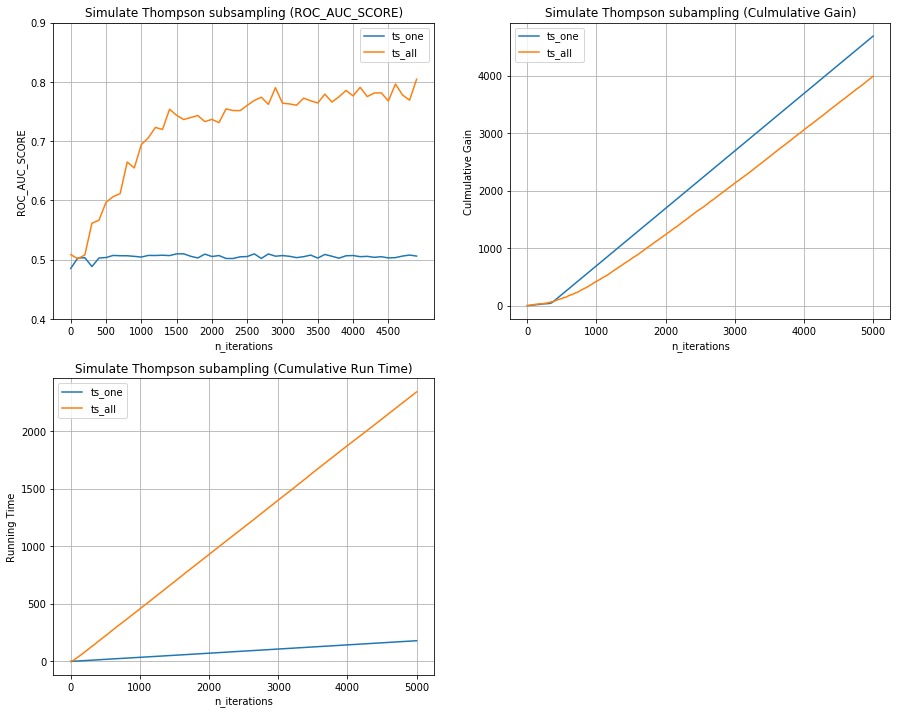

In [7]:
plt.figure(figsize= (15,12))

# only plot 2000 iterations for the purpose of comparison with unrepeated labelling
plt.subplot(221)
plt.plot(results_one['TS_rtrs'][::100], label = 'ts_one')
plt.plot(results_all['TS_rtrs100'][::100], label = 'ts_all')
plt.xticks(numpy.arange(50, step = 5), numpy.arange(5000)[::500])
plt.xlabel('n_iterations')
plt.ylabel('ROC_AUC_SCORE')
plt.ylim(0.4,0.9)
plt.title('Simulate Thompson subsampling (ROC_AUC_SCORE)')
plt.grid(True)
plt.legend()

plt.subplot(222)
plt.plot(numpy.cumsum(results_one['TS_rg']), label = 'ts_one')
plt.plot(numpy.cumsum(results_all['TS_rg100']), label = 'ts_all')
plt.ylabel('Culmulative Gain')
plt.xlabel('n_iterations')
#plt.ylim(0,1300)
plt.title('Simulate Thompson subampling (Culmulative Gain)')
plt.grid(True)
plt.legend()

plt.subplot(223)
plt.plot(numpy.cumsum(results_one['time']), label = 'ts_one')
plt.plot(numpy.cumsum(results_all['time100']), label = 'ts_all')
plt.ylabel('Running Time')
plt.xlabel('n_iterations')
#plt.ylim(0,1300)
plt.title('Simulate Thompson subampling (Cumulative Run Time)')
plt.grid(True)
plt.legend()


Looks like TS stuck on selecting the same triple, which actually gives a label 1.

### Design 2 (Batch Model)

For each iteration, recommend n triples to be labelled, and then use these n labels to update posteriors for all directly related entities and relations.

The update rules could be the same as stated in paper (where $\mathcal{X}_t$ is the observed labells in the $t^{th}$ iteration), but the point is how to recommend n triples in once?

### Design 3

For each iteration, still recommend one triple (i,j,k) to be labelled. Instead of updating only $e_i, e_j, r_k$, also update all entities having relations to $e_i, e_j$ based on past observations using the updated posterior of $e_i, e_j$. Similar for relations. 

### Design 4 (Layer Model)

When we update the posterior of an entity $e_i$, all relations and entities which have path to $e_i$ can be influenced, should we also update these influenced varaibles? Will it cover all entities/relations after a few iterations if the graph is density? 